Benin Random Forest 10km Grid

In [94]:
import numpy
import pandas
import matplotlib.pyplot as plt
import csv
#import seaborn
import sklearn
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%pip install proplot
import proplot as pplt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split

  Using cached proplot-0.9.7-py3-none-any.whl (8.0 MB)
  Using cached matplotlib-3.4.3.tar.gz (37.9 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.4.3-cp310-cp310-linux_x86_64.whl size=7139878 sha256=c586637fe0fb1e4b6ef2057483a3d1e849bb3f0301712929a5bacaea5462b9d4
  Stored in directory: /home/azureuser/.cache/pip/wheels/71/af/e4/d399b616d3e7ae88374c2ebab2d5d3ecf776a3590d4f5f768f
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.8.1
    Uninstalling matplotlib-3.8.1:
      Successfully uninstalled matplotlib-3.8.1

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip3.10 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


AttributeError: module 'matplotlib.cm' has no attribute 'cmap_d'

In [3]:
import random

random.seed(23)

Load in school counts data with other data and make indicator

In [4]:
grid_data = pandas.read_csv("/home/azureuser/cloudfiles/code/Users/ariley/Data/Schools/Africa/School_Counts/Gridded_10km_Data/BEN_Grid_Data_10km_ghsl.csv")

df = grid_data.dropna()

df.head()

df['SCHOOLS'] = [int(i>0) for i in df['NUMPOINTS']]

print(df['SCHOOLS'])

df.head()


0       1
1       0
2       0
3       0
4       0
       ..
1112    1
1113    1
1114    1
1115    1
1116    1
Name: SCHOOLS, Length: 1117, dtype: int64


,Unnamed: 0,x,y,land,built_s,built_v,NUMPOINTS,pop,smod_10,smod_11,smod_12,smod_13,smod_21,smod_22,smod_23,smod_30,id,country,SCHOOLS
0,1,279000,1519000,1000000.00,918.01,2296.19,1,2754.751976,0,91,8,1,0,0,0,0,1,1,1
1,2,249000,1509000,997028.34,4.84,12.14,0,14.602684,0,100,0,0,0,0,0,0,2,1,0
2,3,259000,1509000,999813.00,1.82,4.55,0,5.467709,0,100,0,0,0,0,0,0,3,1,0
3,4,269000,1509000,999934.74,0.20,0.50,0,0.600847,0,100,0,0,0,0,0,0,4,1,0
4,5,279000,1509000,1000000.00,140.01,350.33,0,419.956108,0,99,1,0,0,0,0,0,5,1,0


Make test and train sets, and rescale

In [5]:
train, test = train_test_split(df, test_size = .25, random_state = 42)

print(train.head())


train_y = train['SCHOOLS']
train_x = train[['smod_23', 'smod_21', 'land', 'smod_10', 'y', 'pop', 'built_v', 'smod_12', 'x', 'smod_13', 'smod_11', 'smod_22', 'smod_30', 'built_s']]
test_y = test['SCHOOLS']
test_x = test[['smod_23', 'smod_21', 'land', 'smod_10', 'y', 'pop', 'built_v', 'smod_12', 'x', 'smod_13', 'smod_11', 'smod_22', 'smod_30', 'built_s']]

scaler = StandardScaler()
scale_fit = scaler.fit(train_x)
train_x2 = pandas.DataFrame(scale_fit.transform(train_x))
train_x2.columns = ['smod_23', 'smod_21', 'land', 'smod_10', 'y', 'pop', 'built_v', 'smod_12', 'x', 'smod_13', 'smod_11', 'smod_22', 'smod_30', 'built_s']
test_x2 = pandas.DataFrame(scale_fit.transform(test_x))
test_x2.columns = ['smod_23', 'smod_21', 'land', 'smod_10', 'y', 'pop', 'built_v', 'smod_12', 'x', 'smod_13', 'smod_11', 'smod_22', 'smod_30', 'built_s']

print(train_x2.head())
print(test_x2.head())


     Unnamed: 0       x        y        land  built_s   built_v  NUMPOINTS  \
361         362  249000  1309000   998331.54  1737.64   7461.79          0   
790         791  199000  1089000   999082.12     3.18      7.99          0   
533         534  139000  1239000   998464.07  4800.59  12037.35          8   
708         709  149000  1149000  1000000.00  3541.56   8867.03          2   
583         584  199000  1219000  1000000.00   540.68   1353.81          0   

             pop  smod_10  smod_11  smod_12  smod_13  smod_21  smod_22  \
361  3123.296774        0       98        1        1        0        0   
790     3.796240        0      100        0        0        0        0   
533  4891.346790        0       72       28        0        0        0   
708  4212.937485        0       80       18        2        0        0   
583   463.561106        0      100        0        0        0        0   

     smod_23  smod_30   id  country  SCHOOLS  
361        0        0  362        1    

Comparing Random Forest, kNN and Support Vector Machine

We first just run them with defaults then try tuned

In [48]:
rf_comp = RandomForestClassifier(n_estimators = 200)
knn_comp = KNeighborsClassifier(n_neighbors = 7)
svm_comp = SVC(probability = True)

rf_model = rf_comp.fit(train_x2, train_y)
knn_model = knn_comp.fit(train_x2, train_y)
svm_model = svm_comp.fit(train_x2, train_y)

RandomForestClassifier(n_estimators=200)


In [20]:
pred_rf = rf_model.predict(test_x2)
pred_knn = knn_model.predict(test_x2)
pred_svm = svm_model.predict(test_x2)

print(classification_report(test_y, pred_rf))
print(classification_report(test_y, pred_knn))
print(classification_report(test_y, pred_svm))

              precision    recall  f1-score   support

           0       0.94      0.76      0.84       110
           1       0.86      0.97      0.91       170

    accuracy                           0.89       280
   macro avg       0.90      0.87      0.88       280
weighted avg       0.90      0.89      0.89       280

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       110
           1       0.87      0.92      0.89       170

    accuracy                           0.87       280
   macro avg       0.87      0.85      0.86       280
weighted avg       0.87      0.87      0.87       280

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       110
           1       0.88      0.93      0.90       170

    accuracy                           0.88       280
   macro avg       0.88      0.86      0.87       280
weighted avg       0.88      0.88      0.88       280



Now for probability

In [21]:
test_y2 = test_y.to_numpy()

rf_prob = rf_model.predict_proba(test_x2)
knn_prob = knn_model.predict_proba(test_x2)
svm_prob = svm_model.predict_proba(test_x2)

Predict on All

In [42]:
x = df[['smod_23', 'smod_21', 'land', 'smod_10', 'y', 'pop', 'built_v', 'smod_12', 'x', 'smod_13', 'smod_11', 'smod_22', 'smod_30', 'built_s']]
y = df['SCHOOLS']

y2 = y.to_numpy()

rf_model_all = rf_model.fit(x,y)
rf_prob = rf_model_all.predict_proba(x)

knn_model_all = knn_model.fit(x,y)
knn_prob = knn_model_all.predict_proba(x)

svm_model_all = svm_model.fit(x,y)
svm_prob = svm_model_all.predict_proba(x)


y_pred_rf = rf_prob[:,1]
y_pred_knn = knn_prob[:,1]
y_pred_svm = svm_prob[:,1]

y_out = numpy.column_stack([y2, y_pred_rf, y_pred_knn, y_pred_svm])
print(y_out.__class__.__name__)

y_data = pandas.DataFrame(y_out, columns = ['SCHOOLS', 'Prob_SCHOOLS_rf', 'Prob_SCHOOLS_knn', 'Prob_SCHOOLS_svm'])
print(y_data)

data = y_data.join(x)
print(data)

ndarray
      SCHOOLS  Prob_SCHOOLS_rf  Prob_SCHOOLS_knn  Prob_SCHOOLS_svm
0         1.0            0.760          0.285714          0.199529
1         0.0            0.055          0.000000          0.210243
2         0.0            0.000          0.000000          0.208816
3         0.0            0.000          0.142857          0.207452
4         0.0            0.000          0.285714          0.206908
...       ...              ...               ...               ...
1112      1.0            1.000          1.000000          0.996916
1113      1.0            1.000          1.000000          0.740086
1114      1.0            0.995          1.000000          0.800302
1115      1.0            0.995          1.000000          0.979378
1116      1.0            1.000          1.000000          0.993230

[1117 rows x 4 columns]
      SCHOOLS  Prob_SCHOOLS_rf  Prob_SCHOOLS_knn  Prob_SCHOOLS_svm  smod_23  \
0         1.0            0.760          0.285714          0.199529        0   
1    

<Figure size 640x480 with 0 Axes>

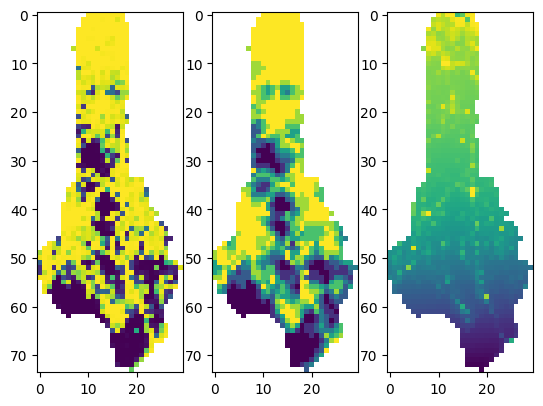

In [43]:
xyz1 = data[['x', 'y', 'Prob_SCHOOLS_rf']]
xyz2 = data[['x', 'y', 'Prob_SCHOOLS_knn']]
xyz3 = data[['x', 'y', 'Prob_SCHOOLS_svm']]

xyz_wide1 = xyz1.pivot(index = 'y', columns = 'x', values = 'Prob_SCHOOLS_rf')
xyz_wide2 = xyz2.pivot(index = 'y', columns = 'x', values = 'Prob_SCHOOLS_knn')
xyz_wide3 = xyz3.pivot(index = 'y', columns = 'x', values = 'Prob_SCHOOLS_svm')

plt.figure()
f, axarr = plt.subplots(1,3)

axarr[0].imshow(xyz_wide1, interpolation='nearest')
axarr[1].imshow(xyz_wide2, interpolation='nearest')
axarr[2].imshow(xyz_wide3, interpolation='nearest')

plt.show()

Very different, lets try tuning


Random Forest Tuning (as before)

Tuned 
RandomForestClassifier(max_depth=120, max_features=7, min_samples_leaf=3,
                       min_samples_split=15, n_estimators=300)

Subset and Tuned
RandomForestClassifier(max_depth=110, max_features=4, min_samples_leaf=4,
                       min_samples_split=20, n_estimators=300)

In [51]:
rf_comp2 = RandomForestClassifier(max_depth=120, max_features=7, min_samples_leaf=3,
                       min_samples_split=15, n_estimators=300)

rf_model2 = rf_comp2.fit(train_x2, train_y)

pred_rf2 = rf_model2.predict(test_x2)

print(classification_report(test_y, pred_rf2))

rf_prob2 = rf_model2.predict_proba(test_x2)

              precision    recall  f1-score   support

           0       0.92      0.76      0.84       110
           1       0.86      0.96      0.91       170

    accuracy                           0.88       280
   macro avg       0.89      0.86      0.87       280
weighted avg       0.89      0.88      0.88       280



In [52]:
param_grid_knn = {
    'leaf_size' : [1,2,3,4,5,6],
    'n_neighbors' : [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20],
    'p' : [1,2],
}

knn_comp2 = KNeighborsClassifier()

grid_search_knn = GridSearchCV(estimator = knn_comp2, param_grid = param_grid_knn, 
                          cv = 5, n_jobs = -1, verbose = 2)


grid_search_knn.fit(train_x2, train_y)
grid_search_knn.best_params_

knn_model2 = grid_search_knn.best_estimator_


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
[CV] END ....................leaf_size=1, n_neighbors=1, p=1; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=1; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=1; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=1; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=1; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=2; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=2; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=2; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=1, p=2; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=2, p=1; total time=   0.0s
[CV] END ....................leaf_size=1, n_neighbors=2, p=1; total time=   0.0s
[CV] END ....................leaf_size=1, n_n

In [59]:
print(knn_model2)

pred_knn2 = knn_model2.predict(test_x2)

print(classification_report(test_y, pred_knn2))

knn_prob2 = knn_model2.predict_proba(test_x2)

KNeighborsClassifier(leaf_size=1, n_neighbors=12, p=1)
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       110
           1       0.88      0.91      0.89       170

    accuracy                           0.87       280
   macro avg       0.86      0.86      0.86       280
weighted avg       0.87      0.87      0.87       280



In [57]:
param_grid_svm = {
    'C' : [0.1, 1, 10, 100, 1000],
    'gamma' : [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel' : ['rbf', 'poly', 'sigmoid'],
}

svm_comp2 = SVC(probability = True)

grid_search_svm = GridSearchCV(estimator = svm_comp2, param_grid = param_grid_svm, 
                          cv = 5, n_jobs = -1, verbose = 2)


grid_search_svm.fit(train_x2, train_y)
grid_search_svm.best_params_

svm_model2 = grid_search_svm.best_estimator_

Fitting 5 folds for each of 75 candidates, totalling 375 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.1s
[CV] END .....................C=0.1, gamma=1, k

In [60]:
print(svm_model2)

pred_svm2 = svm_model2.predict(test_x2)

print(classification_report(test_y, pred_svm2))

svm_prob2 = svm_model2.predict_proba(test_x2)

SVC(C=10, gamma=0.1, probability=True)
              precision    recall  f1-score   support

           0       0.91      0.78      0.84       110
           1       0.87      0.95      0.91       170

    accuracy                           0.88       280
   macro avg       0.89      0.86      0.87       280
weighted avg       0.88      0.88      0.88       280



And predict on all data

In [61]:
x = df[['smod_23', 'smod_21', 'land', 'smod_10', 'y', 'pop', 'built_v', 'smod_12', 'x', 'smod_13', 'smod_11', 'smod_22', 'smod_30', 'built_s']]
y = df['SCHOOLS']

y2 = y.to_numpy()

rf_model_all2 = rf_model2.fit(x,y)
rf_prob2 = rf_model_all2.predict_proba(x)

knn_model_all2 = knn_model2.fit(x,y)
knn_prob2 = knn_model_all2.predict_proba(x)

svm_model_all2 = svm_model2.fit(x,y)
svm_prob2 = svm_model_all2.predict_proba(x)


y_pred_rf2 = rf_prob2[:,1]
y_pred_knn2 = knn_prob2[:,1]
y_pred_svm2 = svm_prob2[:,1]

y_out2 = numpy.column_stack([y2, y_pred_rf2, y_pred_knn2, y_pred_svm2])
print(y_out2.__class__.__name__)

y_data2 = pandas.DataFrame(y_out, columns = ['SCHOOLS', 'Prob_SCHOOLS_rf', 'Prob_SCHOOLS_knn', 'Prob_SCHOOLS_svm'])
print(y_data2)

data2 = y_data2.join(x)
print(data)

ndarray
      SCHOOLS  Prob_SCHOOLS_rf  Prob_SCHOOLS_knn  Prob_SCHOOLS_svm
0         1.0            0.760          0.285714          0.199529
1         0.0            0.055          0.000000          0.210243
2         0.0            0.000          0.000000          0.208816
3         0.0            0.000          0.142857          0.207452
4         0.0            0.000          0.285714          0.206908
...       ...              ...               ...               ...
1112      1.0            1.000          1.000000          0.996916
1113      1.0            1.000          1.000000          0.740086
1114      1.0            0.995          1.000000          0.800302
1115      1.0            0.995          1.000000          0.979378
1116      1.0            1.000          1.000000          0.993230

[1117 rows x 4 columns]
      SCHOOLS  Prob_SCHOOLS_rf  Prob_SCHOOLS_knn  Prob_SCHOOLS_svm  smod_23  \
0         1.0            0.760          0.285714          0.199529        0   
1    

AttributeError: 'Axes' object has no attribute 'cmap'

<Figure size 640x480 with 0 Axes>

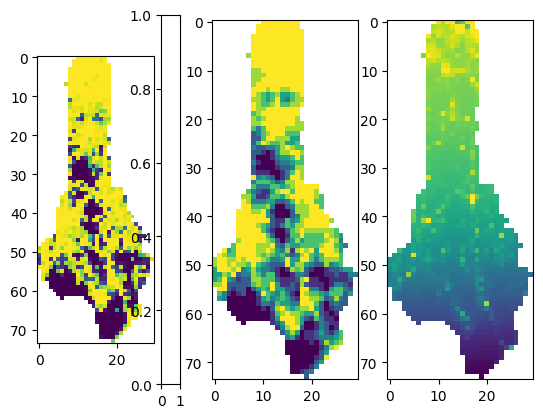

In [78]:
xyz1 = data2[['x', 'y', 'Prob_SCHOOLS_rf']]
xyz2 = data2[['x', 'y', 'Prob_SCHOOLS_knn']]
xyz3 = data2[['x', 'y', 'Prob_SCHOOLS_svm']]

xyz_wide1 = xyz1.pivot(index = 'y', columns = 'x', values = 'Prob_SCHOOLS_rf')
xyz_wide2 = xyz2.pivot(index = 'y', columns = 'x', values = 'Prob_SCHOOLS_knn')
xyz_wide3 = xyz3.pivot(index = 'y', columns = 'x', values = 'Prob_SCHOOLS_svm')


NameError: name 'pplt' is not defined

<Figure size 640x480 with 0 Axes>

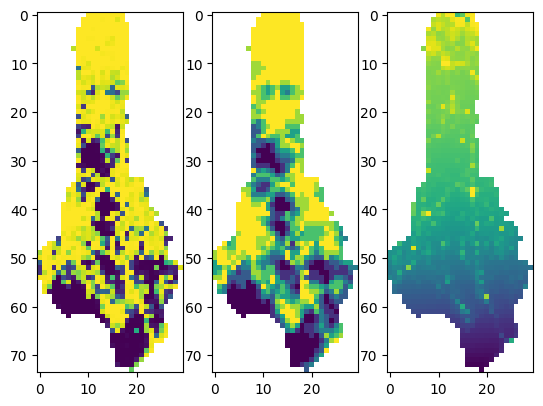

In [92]:
plt.figure()
f, axarr = plt.subplots(1,3)

m1 = axarr[0].imshow(xyz_wide1, cmap = "viridis", interpolation='nearest')
m2 = axarr[1].imshow(xyz_wide2, cmap = "viridis", interpolation='nearest')
m3 = axarr[2].imshow(xyz_wide3, cmap = "viridis", interpolation='nearest')

plt.colorbar(m1, loc = 'b', levels = pplt.arange(0,1))
plt.colorbar(m2)
plt.colorbar(m3)
plt.show()

https://www.wvview.org/os_gisc/python/spatial_ml/site/#compare-algorithms